# Libraries and data

In [1]:
# Imports dependencies
import pandas as pd
import numpy as np
from sklearnex import patch_sklearn
patch_sklearn()
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from datetime import datetime
import optuna
import matplotlib.pyplot as plt
import time
import pickle
import os, glob

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
# Loads the merged_df parquet file
merged_df = pd.read_parquet('data/cleaned_data/merged_df.parquet')

merged_df

,timestamp,precipitation,percentage
0,2019-01-01 00:00:00,0.0,7.895
1,2019-01-01 00:05:00,0.0,7.895
2,2019-01-01 00:10:00,0.0,7.895
3,2019-01-01 00:15:00,0.0,7.895
4,2019-01-01 00:20:00,0.0,7.895
...,...,...,...
507883,2023-11-10 00:40:00,0.0,0.814
507884,2023-11-10 00:45:00,0.0,1.106
507885,2023-11-10 00:50:00,0.0,1.399
507886,2023-11-10 00:55:00,0.0,1.692


# Feature engineering

## Main methods

In [3]:
# Converts datimetime to seperate features
import datetime as dt

def convert_timestamp_to_numerical(dataset):
    dataset = dataset.copy()
    dataset['day'] = dataset['timestamp'].dt.day
    dataset['month'] = dataset['timestamp'].dt.month
    # dataset['year'] = dataset['timestamp'].dt.year
    dataset['dayofweek'] = dataset['timestamp'].dt.dayofweek
    dataset['hour'] = dataset['timestamp'].dt.hour
    # dataset['minute'] = dataset['timestamp'].dt.minute

    # dataset['date'] = pd.to_datetime(dataset['timestamp'])
    # dataset['date'] = dataset['date'].map(dt.datetime.toordinal)

    # Rearranges features: day, month, dayofweek, hour are put behind timestamp
    cols = dataset.columns.tolist()
    cols = cols[0:1] + cols[-4:] + cols[1:-4]
    dataset = dataset[cols]
    
    return dataset

In [4]:
# Split the dataset into training and test sets, and scale the features
start_timestamp_for_specific_testing = pd.to_datetime('2023-03-06 08:00:00')
end_timestamp_for_specific_testing = pd.to_datetime('2023-03-20 08:00:00')

def get_datasets_and_scaler(merged_df, features):
   # Define the features and target variables to be used
   X = merged_df[features]
   y = merged_df['percentage_current']

   # Scale the features
   scaler = StandardScaler()
   scaler.fit(X)
   
   # For testing with specific timeframes
   X_test_specific = merged_df[(merged_df['timestamp'] >= start_timestamp_for_specific_testing) & (merged_df['timestamp'] <= end_timestamp_for_specific_testing)][features]
   X_test_specific = scaler.transform(X_test_specific)
   y_test_specific = merged_df[(merged_df['timestamp'] >= start_timestamp_for_specific_testing) & (merged_df['timestamp'] <= end_timestamp_for_specific_testing)]['percentage_current']
   
   X = scaler.transform(X)

   # Create the training and test sets
   X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=41, shuffle=True)

   return X_train, X_test, y_train, y_test, scaler, X_test_specific, y_test_specific

## Helper methods

In [5]:
# Gets metrics for the model and prints them
def test_model(model, X_test, y_test, predictions):
    # Calculate the accuracy of the model
    accuracy = model.score(X_test, y_test)
    accuracy = round(accuracy * 100, 2)
    print(f"Accuracy: {accuracy}%")

    # Calculate the mean squared error of the model
    mse = mean_squared_error(y_test, predictions)
    print(f"Mean squared error: {mse}")

    # Calculate the R-Squared score of the model
    print('Variance (R²) score: %.2f' % r2_score(y_test, predictions))

# Calculate the Friedman Mean Squared Error between true and predicted values.
def friedman_mse_calculate(y_true, y_pred):
    n = len(y_true)
    if n <= 1:
        return 0
    
    slopes = np.gradient(y_pred, edge_order=2)
    adjustment = np.sum(slopes ** 2) / (n - 1)
    mse = mean_squared_error(y_true, y_pred)
    friedman_mse_value = mse + adjustment
    
    return friedman_mse_value

# Trains and returns evaluation metrics for the model
def optuna_linear_train_evaluate(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    
    # Make predictions and evaluate the model
    predictions = model.predict(X_test)
    
    accuracy = model.score(X_test, y_test)
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    # friedman_mse = mean_squared_error(y_test, predictions, multioutput='raw_values')
    # friedman_mse = friedman_mse_calculate(y_test, predictions)
    
    # return accuracy
    return accuracy, mse, r2
    # return accuracy, r2, friedman_mse
    # return friedman_mse

# Saves file to pickle
def save_to_pickle_file(file, filename):
    pickle.dump(file, open(filename, 'wb'))

# Plots the predictions against the actual values
def plot_predicted_vs_actual(y_test, predictions):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, predictions)
    plt.xlabel('Actual percentage')
    plt.ylabel('Predicted percentage')
    plt.title('Predicted percentage vs. Actual percentage')
    plt.show()

# Prints the time taken
def print_time_taken(start_time, end_time):
    print(f"Time taken: {time.strftime('%H:%M:%S', time.gmtime(end_time - start_time))}")

## Control notebook and define features

In [6]:
# Define what needs to be done
train_model = False # trains a model
calibrate_lag_features = False # optimizes lag features

# Define what lag features should be used
optimized_lag_features = False # uses optimized lag features

# Define what timeframe should be used for testing (only works with optuna training)
use_specific_testset = True # uses specific testing timeframe

# Define how should be trained (not needed for lag feature calibration)
use_manual_training = False # uses manual training
use_optuna_training = False # uses optuna to optimize hyperparameters
use_gridsearch_training = True # uses gridsearch to optimize hyperparameters (only Random Forest)

# Define what model needs to be trained
linear_model = False
ridge_model = False
lasso_model = False
elastic_net_model = False
polynomial_model = False
random_forest_model = True
tpot = False

if optimized_lag_features:
    rainfall_lag = 23
    percentage_lag = 11
else:
    rainfall_lag = 25
    percentage_lag = 6

# Define the features to be used
date_features = ['day', 'month', 'dayofweek', 'hour']
rainfall_features = ['rainfall_current', 'rainfall_previous_2_hours']
percentage_previous_features = ['percentage_previous_1', 'percentage_previous_2', 'percentage_previous_3', 'percentage_previous_4', 'percentage_previous_5', 'percentage_previous_6']
percentage_previous_features_optimized = ['percentage_previous_1', 'percentage_previous_2', 'percentage_previous_3', 'percentage_previous_4', 'percentage_previous_5', 'percentage_previous_6', 'percentage_previous_7', 'percentage_previous_8', 'percentage_previous_9', 'percentage_previous_10', 'percentage_previous_11']

if(calibrate_lag_features):
    features = date_features + rainfall_features
elif(optimized_lag_features):
    features = date_features + rainfall_features + percentage_previous_features_optimized
else:
    features = date_features + rainfall_features + percentage_previous_features

features

['day',
 'month',
 'dayofweek',
 'hour',
 'rainfall_current',
 'rainfall_previous_2_hours',
 'percentage_previous_1',
 'percentage_previous_2',
 'percentage_previous_3',
 'percentage_previous_4',
 'percentage_previous_5',
 'percentage_previous_6']

In [7]:
# Customize features

# Rename columns
merged_df.rename(columns={'precipitation': 'rainfall_current'}, inplace=True)
merged_df.rename(columns={'percentage': 'percentage_current'}, inplace=True)

if(not calibrate_lag_features):
    # Sums up the rainfall_current of the previous x records and puts it into a new column
    merged_df['rainfall_previous_2_hours'] = merged_df['rainfall_current'].rolling(rainfall_lag).sum() - merged_df['rainfall_current']
    merged_df['rainfall_previous_2_hours'].fillna(0, inplace=True)

    # Puts the percentage of the previous x records in new columns
    for shift_rate in range(1, percentage_lag + 1):
        merged_df[f'percentage_previous_{shift_rate}'] = merged_df['percentage_current'].shift(shift_rate)
        merged_df[f'percentage_previous_{shift_rate}'].fillna(0, inplace=True)

    # # EXTRA LAF FEATURES
    # rainfall_lag_start = 12
    # # Shifts rainfall_current an uses a for loop to create rainfall_previous_1 to rainfall_previous_6
    # for shift_rate in range(1, 7):
    #     merged_df[f'rainfall_previous_{shift_rate}'] = merged_df['rainfall_current'].shift(shift_rate + rainfall_lag_start)
    #     merged_df[f'rainfall_previous_{shift_rate}'].fillna(0, inplace=True)
            
    # # the difference between the current percentage and the previous 6 percentage in new columns
    # for shift_rate in range(1, 7):
    #     merged_df[f'percentage_difference_{shift_rate}'] = merged_df['percentage_current'].shift(shift_rate) - merged_df['percentage_current'].shift(shift_rate + 1)
    #     merged_df[f'percentage_difference_{shift_rate}'].fillna(0, inplace=True)

print('Are there null values?', merged_df.isnull().values.any())

merged_df = convert_timestamp_to_numerical(merged_df)

print(merged_df.dtypes)
# merged_df

Are there null values? False
timestamp                    datetime64[ns]
day                                   int32
month                                 int32
dayofweek                             int32
hour                                  int32
rainfall_current                    float64
percentage_current                  float64
rainfall_previous_2_hours           float64
percentage_previous_1               float64
percentage_previous_2               float64
percentage_previous_3               float64
percentage_previous_4               float64
percentage_previous_5               float64
percentage_previous_6               float64
dtype: object


In [8]:
# Defines the data when not calibrating lag features
if(not calibrate_lag_features):
    # Gets the datasets and scaler
    X_train, X_test, y_train, y_test, scaler, X_test_specific, y_test_specific = get_datasets_and_scaler(merged_df, features)

    if train_model:
        # Saves scaler to pickle file
        filename = 'scalers/scaler_' + datetime.now().strftime("%Y%m%d-%H%M%S") + '.pkl'
        pickle.dump(scaler, open(filename, 'wb'))

        def scale_features(features):
            return scaler.transform(features)

## Lag features tuning

In [9]:
# Tune lag features rain and percentage
if calibrate_lag_features:
    # Shows minimal output
    optuna.logging.set_verbosity(optuna.logging.WARNING)

    # Define what needs to be calibrated, you can calibrate both at the same time
    rainfall_cumulative_calibration = True
    percentage_previous_calibration = True

    if rainfall_cumulative_calibration and not percentage_previous_calibration:
        print("TUNING RAINFALL CUMULATIVE - Percentage previous filled")
        for shift_rate in range(1, 7):
            merged_df[f'percentage_previous_{shift_rate}'] = merged_df['percentage_current'].shift(shift_rate)
            merged_df[f'percentage_previous_{shift_rate}'].fillna(0, inplace=True)
        
        features = features + percentage_previous_features
    elif percentage_previous_calibration and not rainfall_cumulative_calibration:
        print("TUNING PERCENTAGE PREVIOUS - Rainfall cumulative filled")
        merged_df['rainfall_previous_2_hours'] = merged_df['rainfall_current'].rolling(26).sum() - merged_df['rainfall_current']
        merged_df['rainfall_previous_2_hours'].fillna(0, inplace=True)

    print("features:", features)

    def objective(trial):
        merged_df_optuna = merged_df.copy()

        # Rainfall cumulative tuning
        if rainfall_cumulative_calibration:
            shift_rainfall_cumulative = None
            roll_rainfall_cumulative = None

            # Everything in try block, suggestion can result as None and throw error
            try:     
                # Suggest hyperparameters
                shift_rainfall_cumulative = trial.suggest_int('shift_rainfall_param', 0, 60)
                roll_rainfall_cumulative = trial.suggest_int('roll_rainfall_param', 2, 60)
            except Exception as e_1:
                print(f"Exception: {e_1}")
                if shift_rainfall_cumulative is None:
                    print('-> shift is None')
                    shift_rainfall_cumulative = 0
                    try: 
                        roll_rainfall_cumulative = trial.suggest_int('roll_rainfall_param', 2, 60)
                    except Exception as e_2:
                        print(f"Exception: {e_2}")
                        if roll_rainfall_cumulative is None:
                            print('-> shift and roll are None')
                            roll_rainfall_cumulative = 2
                
                if roll_rainfall_cumulative is None:
                    print('-> roll is None')
                    roll_rainfall_cumulative = 2
        
            # Apply suggested params to rainfall cumulative
            start_record = merged_df_optuna['rainfall_current'].shift(shift_rainfall_cumulative)
            
            if start_record.isnull().values.any():
                merged_df_optuna['rainfall_previous_2_hours'] = 0
            else:
                rollback_sum = start_record.rolling(roll_rainfall_cumulative).sum().fillna(0)
                merged_df_optuna['rainfall_previous_2_hours'] = rollback_sum - start_record
        
            # merged_df_optuna['rainfall_previous_2_hours'].fillna(0, inplace=True)

            if not percentage_previous_calibration:            
                X_train, X_test, y_train, y_test, scaler, X_test_specific, y_test_specific = get_datasets_and_scaler(merged_df_optuna, features)

        # Percentage previous tuning
        if percentage_previous_calibration:
            percentage_previous_features = []
            try:     
                # Suggest hyperparameters
                shift_percentage_previous = trial.suggest_int('shift_percentage_param', 1, 60)
                roll_percentage_previous = trial.suggest_int('roll_percentage_param', 1, 60)
            except Exception as e_1:
                print(f"Exception: {e_1}")
                if shift_percentage_previous is None:
                    print('-> shift percentage is None')
                    shift_percentage_previous = 1
                    try: 
                        roll_percentage_previous = trial.suggest_int('roll_percentage_param', 1, 60)
                    except Exception as e_2:
                        print(f"Exception: {e_2}")
                        if roll_percentage_previous is None:
                            print('-> shift and roll percentage are None')
                            roll_percentage_previous = 1
                
                if roll_percentage_previous is None:
                    print('-> roll is None')
                    roll_percentage_previous = 1

            # The percentage of the previous x records in new columns
            for roll in range(1, roll_percentage_previous + 1):
                previous_value = merged_df_optuna['percentage_current'].shift(shift_percentage_previous + roll - 1).fillna(0)   
                merged_df_optuna[f'percentage_previous_{roll}'] = previous_value

                # merged_df_optuna[f'percentage_previous_{roll}'].fillna(0, inplace=True)
                percentage_previous_features.append(f'percentage_previous_{roll}')

            X_train, X_test, y_train, y_test, scaler, X_test_specific, y_test_specific = get_datasets_and_scaler(merged_df_optuna, features + percentage_previous_features)

        model = LinearRegression()
        model.fit(X_train, y_train)

        # Make predictions and evaluate the model
        if use_specific_testset:
            predictions = model.predict(X_test_specific)

            accuracy = model.score(X_test_specific, y_test_specific)
            mse = mean_squared_error(y_test_specific, predictions)
            r2 = r2_score(y_test_specific, predictions)
        else:
            predictions = model.predict(X_test)

            accuracy = model.score(X_test, y_test)
            mse = mean_squared_error(y_test, predictions)
            r2 = r2_score(y_test, predictions)

        # Checks if accuracy, mse or r2 is None, metric may result as None and will throw error
        if accuracy is None or mse is None or r2 is None:
            print('Metrics:', accuracy, mse, r2)
            if accuracy is None:
                accuracy = 0
            if mse is None:
                mse = 9999999
            if r2 is None:
                r2 = 0

        return accuracy, mse, r2 # The objective to be maximized

    # Initialize Optuna study
    # study = optuna.create_study(direction="maximize")
    study = optuna.create_study(directions=["maximize", "minimize", "maximize"])

    # Tracks time
    start_time = time.time()

    # Optimize the study, the objective function is called here
    study.optimize(objective, n_trials=20000, n_jobs=120, show_progress_bar=True)  # Adjust n_trials for your needs

    print_time_taken(start_time, time.time())

    # Print the best parameters
    for best_trial in study.best_trials:
        print(f"Best values: {best_trial.values} | best params: {best_trial.params}")

# MODEL TRAINING

## TPOT

In [10]:
# Find best model and hyperparameters with TPOT
if train_model and tpot:
    # Use TPOT to find the best model
    from tpot import TPOTRegressor

    # Use TPOT to find the best model
    tpot = TPOTRegressor(generations=10, population_size=50, n_jobs=-1, verbosity=2, random_state=41)

    # track time in hours and minutes
    start_time = time.time()

    tpot.fit(X_train, y_train)

    # Print the time elapsed
    print_time_taken(start_time, time.time())

    print(tpot.score(X_test, y_test))
    tpot.export('tpot_exported_pipeline.py')

    # Make predictions on the test set
    predictions = tpot.predict(X_test)

    # Calculate the accuracy of the model
    test_model(tpot, X_test, y_test, predictions)

    # Plot the predictions against the actual values
    plot_predicted_vs_actual(y_test, predictions)

In [11]:
# # TPOT result insertion
# from sklearn.svm import LinearSVR
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.linear_model import RidgeCV
# from tpot.builtins import StackingEstimator
# from xgboost import XGBRegressor
# from tpot.export_utils import set_param_recursive


# # # Average CV score on the training set was: -0.6345471715614988 - WITH LAG FEATURES OPTIMIZED
# # exported_pipeline = make_pipeline(
# #     StackingEstimator(estimator=RidgeCV()),
# #     StackingEstimator(estimator=RidgeCV()),
# #     DecisionTreeRegressor(max_depth=10, min_samples_leaf=17, min_samples_split=10)
# # )

# # Average CV score on the training set was: -0.8932366080404688 - WITHOUT LAG FEATURES OPTIMIZED
# exported_pipeline = make_pipeline(
#     StackingEstimator(estimator=RidgeCV()),
#     MinMaxScaler(),
#     XGBRegressor(learning_rate=0.1, max_depth=8, min_child_weight=19, n_estimators=100, n_jobs=1, objective="reg:squarederror", subsample=0.45, verbosity=0)
# )

# # Fix random state for all the steps in exported pipeline
# set_param_recursive(exported_pipeline.steps, 'random_state', 41)

# # track time in hours and minutes
# start_time = time.time()

# exported_pipeline.fit(X_train, y_train)

# # Print the time elapsed
# print_time_taken(start_time, time.time())

# predictions = exported_pipeline.predict(X_test)

# test_model(exported_pipeline, X_test, y_test, predictions)

# # save model to folder models\linear_regression with a timestamp in the name
# filename = f'models/best_models/model_TPOT2_{datetime.now().strftime("%Y%m%d-%H%M%S")}.pkl'
# save_to_pickle_file(exported_pipeline, filename)

## Linear models

In [12]:
# Train linear regression default, ridge, lasso and elastic net models
if(train_model and use_manual_training and (linear_model or ridge_model or lasso_model or elastic_net_model)):
    model_type = None

    # Track time
    start_time = time.time()

    if(linear_model):
        # Creates the linear regression model and train/fits it
        print('linear model is training...')
        model = LinearRegression()
        model.fit(X_train, y_train)
        model_type = 'linear_regression'
    elif(ridge_model):
        # Creates the ridge regression model and train/fits it, uses GridSearchCV to find the best alpha
        print('ridge model is training...')
        model = Ridge()
        parameters = {'alpha': [1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001]}
        ridge_regressor = GridSearchCV(model, parameters, n_jobs=-1)
        ridge_regressor.fit(X_train, y_train)
        print(ridge_regressor.best_params_)
        model = ridge_regressor.best_estimator_
        model_type = 'ridge_regression'
    elif(lasso_model):
        # Creates the lasso regression model and train/fits it, uses GridSearchCV to find the best alpha
        print('lasso model is training...')
        model = Lasso(max_iter=5000)
        parameters = {'alpha': [1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001]}
        lasso_regressor = GridSearchCV(model, parameters, n_jobs=-1)
        lasso_regressor.fit(X_train, y_train)
        print(lasso_regressor.best_params_)
        model = lasso_regressor.best_estimator_
        model_type = 'lasso_regression'
    elif(elastic_net_model):
        # Creates the elastic net regression model and train/fits it, uses GridSearchCV to find the best alpha and l1_ratio
        print('elastic net model is training...')
        model = ElasticNet(max_iter=5000)
        parameters = {'alpha': [1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001], 'l1_ratio': [0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9]}
        elastic_net_regressor = GridSearchCV(model, parameters, n_jobs=-1)
        elastic_net_regressor.fit(X_train, y_train)
        print(elastic_net_regressor.best_params_)
        model = elastic_net_regressor.best_estimator_
        model_type = 'elastic_net_regression'
    
    # Prints the time elapsed
    print_time_taken(start_time, time.time())

    # Makes predictions on the test set
    predictions = model.predict(X_test)

    # Tests the model
    test_model(model, X_test, y_test, predictions)

    # Plots the predictions against the actual values
    plot_predicted_vs_actual(y_test, predictions)

    # Saves model to folder models\linear_regression with a timestamp in the name
    filename = f'models/linear_regression/model_{model_type}_{datetime.now().strftime("%Y%m%d-%H%M%S")}.pkl'
    save_to_pickle_file(model, filename)

In [13]:
# Train linear regression ridge, lasso and elastic net models using Optuna
if train_model and use_optuna_training and (ridge_model or lasso_model or elastic_net_model):
    # Shows minimal output
    optuna.logging.set_verbosity(optuna.logging.WARNING)

    # Ridge
    if ridge_model or lasso_model:
        if ridge_model:
            print('ridge model hyperparams are tuned...')
        else:
            print('lasso model hyperparams are tuned...')

        def objective(trial):
            # Suggest hyperparameter alpha
            alpha = trial.suggest_float('alpha', 0.0001, 1)
            
            # Create and train the Random Forest model
            if ridge_model:
                model = Ridge(alpha=alpha, random_state=41)
            elif lasso_model:
                model = Lasso(alpha=alpha, max_iter=5000, random_state=41)

            if use_specific_testset:
                return optuna_linear_train_evaluate(model, X_train, y_train, X_test_specific, y_test_specific)
            else:
                return optuna_linear_train_evaluate(model, X_train, y_train, X_test, y_test)
    elif elastic_net_model:
        print('elastic net model hyperparams are tuned...')
        def objective(trial):
            # Suggest hyperparameter alpha and l1_ratio
            alpha = trial.suggest_float('alpha', 0.0001, 1)
            l1_ratio = trial.suggest_float('l1_ratio', 0.01, 1)
            
            # Create and train the Random Forest model
            model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=5000, random_state=41)

            if use_specific_testset:
                return optuna_linear_train_evaluate(model, X_train, y_train, X_test_specific, y_test_specific)
            else:
                return optuna_linear_train_evaluate(model, X_train, y_train, X_test, y_test)
            
    # Initializes Optuna study
    # study = optuna.create_study(direction="minimize")
    study = optuna.create_study(directions=["maximize", "minimize", "maximize"])
    
    # Tracks time
    start_time = time.time()
    
    # Optimize the study
    study.optimize(objective, n_trials=10000, n_jobs=-1, show_progress_bar=True)  # Adjust n_trials for your needs
    
    # Prints time taken
    print_time_taken(start_time, time.time())
    
    # Prints the best parameters
    for best_trial in study.best_trials:
        print(f"Best values: {best_trial.values} | best params: {best_trial.params}")


In [14]:
# Train polynomial linear regression
if(train_model and use_manual_training and polynomial_model):   
    polynomial_degrees = [2, 3, 4]
    accuracy_score_highest = 0
    best_predictions = None
    best_model = None

    # Tracks time
    start_time = time.time()

    for degree in polynomial_degrees:
        print("Polynomial degree: ", degree)

        # Creates the linear regression model and train/fit it
        model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
        model.fit(X_train, y_train)

        # Makes predictions on the test set
        predictions = model.predict(X_test)

        # Calculates the metrics of the model
        accuracy_initial = model.score(X_test, y_test)
        accuracy = round(accuracy_initial * 100, 2)
        print(f"Accuracy: {accuracy}%")

        # Calculates the mean squared error of the model
        mse = mean_squared_error(y_test, predictions)
        print(f"Mean squared error: {mse}")

        # Calculates the R-Squared score of the model
        print('Variance (R²) score: %.2f' % r2_score(y_test, predictions))
        
        # save model to folder models\linear_regression with a timestamp in the name
        filename = f'models/linear_regression/model_poly_{degree}_{datetime.now().strftime("%Y%m%d-%H%M%S")}.pkl'
        pickle.dump(model, open(filename, 'wb'))

        if (accuracy_initial > accuracy_score_highest):
            accuracy_score_highest = accuracy_initial
            best_predictions = predictions
            best_model = model

    # Prints the time elapsed
    print_time_taken(start_time, time.time())

    model = best_model

    # Plots the predictions against the actual values
    plot_predicted_vs_actual(y_test, best_predictions)

In [15]:
# Train polynomial linear using Optuna 
if train_model and use_optuna_training and polynomial_model:
    print('polynomial model hyperparams are tuned...')
    
    # show minimal output
    optuna.logging.set_verbosity(optuna.logging.WARNING)

    def objective(trial):
    # Suggest hyperparameters degree and alpha
        degree = trial.suggest_int('degree', 2, 4)
        alpha = trial.suggest_float('alpha', 0.001, 1)

        # Creates the linear regression model and train/fit it
        model = make_pipeline(PolynomialFeatures(degree), Ridge(alpha=alpha, random_state=41))
        model.fit(X_train, y_train)

        if use_specific_testset:
            return optuna_linear_train_evaluate(model, X_train, y_train, X_test_specific, y_test_specific)
        else:
            return optuna_linear_train_evaluate(model, X_train, y_train, X_test, y_test)
            
    # Initializes Optuna study
    study = optuna.create_study(directions=["maximize", "minimize", "maximize"])
    
    # Tracks time
    start_time = time.time()
    
    # Optimizes the study
    study.optimize(objective, n_trials=10, n_jobs=-1, show_progress_bar=True)  # Adjust n_trials for your needs
    
    # Prints time taken
    print_time_taken(start_time, time.time())
    
    # Prints the best parameters
    for best_trial in study.best_trials:
        print(f"Best values: {best_trial.values} | best params: {best_trial.params}")

## Random forest

In [16]:
# Random Forest with for-loop
if(train_model and use_manual_training and random_forest_model):
    accuracy_score_highest = 0
    best_predictions = None
    best_model = None
    criterion = ['squared_error', 'friedman_mse', 'poisson', 'absolute_error']
    current_criterion = criterion[1]
    
    for n_estimators in range(1, 21):
        # Comment out below for loop out if you don't want to use a specific max_depth
        # for max_depth in range(1, 51):

        # Comment out below for loop out if you're using a specific criterion
        # for current_criterion in criterion:

        print(f"---- n_estimators: {n_estimators}")
        # print(f"---- n_estimators: {n_estimators} - max_depth: {max_depth}")

        print(f"---- criterion: {current_criterion}")

        # Creates the random forest model and train/fit it
        model = RandomForestRegressor(n_estimators=n_estimators, criterion=current_criterion, n_jobs=-1, random_state=41)
        # model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, criterion=current_criterion, n_jobs=-1, random_state=41)

        start = time.time()
        model.fit(X_train, y_train)
        print_time_taken(start, time.time())
        
        if use_specific_testset:
            # Make predictions on the test set
            predictions = model.predict(X_test_specific)

            accuracy = model.score(X_test_specific, y_test_specific)
            accuracy_score = round(accuracy * 100, 2)
            mean_squared_error_test = mean_squared_error(y_test_specific, predictions)
            r2_score_test = r2_score(y_test_specific, predictions)
        else:
            # Makes predictions on the test set
            predictions = model.predict(X_test)

            accuracy = model.score(X_test, y_test)
            accuracy_score = round(accuracy * 100, 2)
            mean_squared_error_test = mean_squared_error(y_test, predictions)
            r2_score_test = r2_score(y_test, predictions)

        # (DISABLE WHEN SAVING INSIDE BELOW IF STATEMENT)
        # filename = f'models/random_forest/model_rf_{current_criterion}_{n_estimators}.pkl'
        # filename = f'models/random_forest/model_rf_{current_criterion}_{n_estimators}_{max_depth}.pkl'
        # save_to_pickle_file(model, filename)

        if (accuracy > accuracy_score_highest):
            accuracy_score_highest = accuracy
            
            # Evaluates the model
            if use_specific_testset:
                test_model(model, X_test_specific, y_test_specific, predictions)
            else:
                test_model(model, X_test, y_test, predictions)

            # Removes evertyhing in folder models\random_forest that starts with model_ (DISABLE WHEN SAVING OUTSIDE IF STATEMENT)
            files = glob.glob('models/random_forest/model_*')
            for f in files:
                os.remove(f)

            # Saves model to folder models\random_forest with a timestamp in the name (DISABLE WHEN SAVING OUTSIDE IF STATEMENT)
            filename = f'models/random_forest/model_rf_{n_estimators}.pkl'
            # filename = f'models/random_forest/model_rf_{n_estimators}_{max_depth}.pkl'
            save_to_pickle_file(model, filename)

            best_predictions = predictions
            best_model = model

    model = best_model

    # Plots the predictions against the actual values
    if use_specific_testset:
        plot_predicted_vs_actual(y_test_specific, best_predictions)
    else:
        plot_predicted_vs_actual(y_test, best_predictions)

In [17]:
# Random Forest with GridSearchCV
# Custom scorer
friedman_mse_score = make_scorer(friedman_mse_calculate, greater_is_better=False)

regression_metrics = [
    'explained_variance', 
    'neg_mean_squared_log_error', 
    'neg_mean_poisson_deviance', 
    'neg_mean_gamma_deviance', 
    'neg_root_mean_squared_error', 
    'max_error', 
    'neg_mean_absolute_error', 
    'neg_mean_squared_error', 
    'neg_median_absolute_error', 
    'neg_mean_absolute_percentage_error'
]

if train_model and use_gridsearch_training and random_forest_model:
    # Remove for loop line if you want to train using single metric
    for metric in regression_metrics:
        print(f"---- metric: {metric}")
        best_predictions = None
        best_model = None

        # Defines one parameter grid for GridSearchCV
        param_grid = {
            'n_estimators': range(1, 6)
        }
        
        # #  Defines two parameter grids for GridSearchCV
        # param_grid = {
        #     'n_estimators': range(1, 51),
        #     'max_depth': range(1, 51)
        # }

        # Creates the Random Forest model
        # model = RandomForestRegressor(n_jobs=-1, random_state=41)
        model = RandomForestRegressor(criterion='friedman_mse', n_jobs=-1, random_state=41)

        # Performs Grid Search to find the best hyperparameters
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring=metric, cv=5, n_jobs=-1, verbose=0)

        # Tracks time
        start_time = time.time()

        grid_search.fit(X_train, y_train)

        # Prints the time elapsed
        print_time_taken(start_time, time.time())

        # Gets the best model and its parameters
        model = grid_search.best_estimator_
        best_params = grid_search.best_params_

        # Makes predictions on the test set using the best model
        predictions = model.predict(X_test)

        print("Best parameters:", best_params)

        # Evaluates the best model
        test_model(model, X_test, y_test, predictions)

        # Saves the model
        filename = f'models/random_forest/best_model_{metric}_{datetime.now().strftime("%Y%m%d-%H%M%S")}.pkl'
        save_to_pickle_file(model, filename)

        # Plot the predictions against the actual values
        plot_predicted_vs_actual(y_test, predictions)

In [18]:
# Random Forest with Optuna
if train_model and use_optuna_training and random_forest_model:
    # Shows minimal output
    optuna.logging.set_verbosity(optuna.logging.WARNING)

    def objective(trial):
        # Suggest hyperparameters n_estimators and max_depth
        n_estimators = trial.suggest_int('n_estimators', 1, 50)
        max_depth = trial.suggest_int('max_depth', 1, 50)
        
        # Creates and train the Random Forest model
        model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, criterion='friedman_mse', n_jobs=-1, random_state=41)
        model.fit(X_train, y_train)
        
        
        # Make predictions and evaluate the model
        if use_specific_testset:
            predictions = model.predict(X_test_specific)
            
            accuracy = model.score(X_test_specific, y_test_specific)
            mse = mean_squared_error(y_test_specific, predictions)
            r2 = r2_score(y_test_specific, predictions)
        else:
            predictions = model.predict(X_test)
            
            accuracy = model.score(X_test, y_test)
            mse = mean_squared_error(y_test, predictions)
            r2 = r2_score(y_test, predictions)
        
        # return accuracy
        return accuracy, mse, r2
        # return friedman_mse_calculate(y_test_specific, predictions)
    
    # Initializes Optuna study
    # study = optuna.create_study(direction="minimize")
    study = optuna.create_study(directions=["maximize", "minimize", "maximize"])
    
    # Tracks time
    start_time = time.time()
    
    # Optimizes the study
    study.optimize(objective, n_trials=2500, n_jobs=-1, show_progress_bar=True)  # Adjust n_trials for your needs
    
    # Prints time taken
    print_time_taken(start_time, time.time())
    
    # Prints the best parameters
    for best_trial in study.best_trials:
        print(f"Best values: {best_trial.values} | best params: {best_trial.params}")

# Evaluate and plot results

In [19]:
# Plot the prediction power of the features that model is using, in a horizontal bar chart
if(train_model and not random_forest_model and not polynomial_model and not tpot):
    plt.figure(figsize=(10, 6))
    plt.barh(features, model.coef_)
    plt.xlabel('Coefficient')
    plt.ylabel('Features')
    plt.title('Feature coefficients')
    plt.show()
elif(train_model and random_forest_model):
    plt.figure(figsize=(10, 6))
    plt.barh(features, model.feature_importances_)
    plt.xlabel('Feature importance')
    plt.ylabel('Features')
    plt.title('Feature importance')
    plt.show()

In [20]:
# Shifts weather data 6 months later to synthesize future weather data
weather_data_6_months_later = merged_df.copy()
weather_data_6_months_later['timestamp'] = weather_data_6_months_later['timestamp'] + pd.DateOffset(months=6)
weather_data_6_months_later = weather_data_6_months_later[['timestamp', 'rainfall_current', 'rainfall_previous_2_hours']]
weather_data_6_months_later

,timestamp,rainfall_current,rainfall_previous_2_hours
0,2019-07-01 00:00:00,0.0,0.0
1,2019-07-01 00:05:00,0.0,0.0
2,2019-07-01 00:10:00,0.0,0.0
3,2019-07-01 00:15:00,0.0,0.0
4,2019-07-01 00:20:00,0.0,0.0
...,...,...,...
507883,2024-05-10 00:40:00,0.0,0.0
507884,2024-05-10 00:45:00,0.0,0.0
507885,2024-05-10 00:50:00,0.0,0.0
507886,2024-05-10 00:55:00,0.0,0.0


In [21]:
# Set information presentation
make_prediction_verbose = False
predictions_to_excel = False

In [22]:
# Formats data to input data for prediction
def data_to_input(dataset, percentages_previous, start_timestamp):
    data_specific_timestamp = dataset[dataset['timestamp'] == start_timestamp]
    data_specific_timestamp = convert_timestamp_to_numerical(data_specific_timestamp)
    
    day = data_specific_timestamp['day'].values[0]
    month = data_specific_timestamp['month'].values[0]
    dayofweek = data_specific_timestamp['dayofweek'].values[0]
    hour = data_specific_timestamp['hour'].values[0]
    date_features = [day, month, dayofweek, hour]

    rainfall_current = data_specific_timestamp["rainfall_current"].values[0]
    rainfall_previous_2_hours = data_specific_timestamp['rainfall_previous_2_hours'].values[0]
   
    percentage_previous_array = []

    for i in range(0, percentage_lag):
        locals()[f'percentage_previous_{i + 1}'] = percentages_previous[i]
        percentage_previous_array.append(locals()[f'percentage_previous_{i + 1}'])

    input_df = pd.DataFrame([date_features + [rainfall_current, rainfall_previous_2_hours] + percentage_previous_array], columns=features)

    if make_prediction_verbose:
        print('----INPUT_DF----\n', input_df.values)
    
    return input_df

In [23]:
# Perform predictions
def create_initial_predictions_df(start_timestamp, weather_data, model, scaler, range_previous_percentage):
    initial_timestamps_minus = []
    initial_previous_percentage = [0] * range_previous_percentage
    pre_predictions_df = None
    
    # Save the previous x amount of timestamps to use for the pre-prediction
    for i in range(1, range_previous_percentage + 1):
        start_timestamp_minus = start_timestamp - pd.Timedelta(minutes=i*5)
        initial_timestamps_minus.append(start_timestamp_minus)
    
    # Turn around initial_timestamps_minus so that it starts 
    initial_timestamps_minus.reverse()
    
    if make_prediction_verbose:
        print('------ PRE-PREDICTION DATES-------\n', initial_timestamps_minus)

    # Make the initial prediction and add it to the initial_previous_percentage, and use this for the next pre-prediction
    for start_timestamp_minus in initial_timestamps_minus:
        if make_prediction_verbose:
            print('------ CURRENT PRE-PREDICTION DATE:', start_timestamp_minus)
            
        weather_data_minus = convert_timestamp_to_numerical(weather_data[weather_data['timestamp'] == start_timestamp_minus])
        
        input_minus = data_to_input(weather_data_minus, initial_previous_percentage, start_timestamp_minus)

        prediction_minus = np.clip(model.predict(scaler.transform(input_minus))[0], 0, 100)

        if make_prediction_verbose:
            print('------CURRENT PRE-PREDICTION RESULT:', prediction_minus)

        # Adds prediction_minus to the front of initial_previous_percentage
        initial_previous_percentage.insert(0, prediction_minus)
        initial_previous_percentage.pop()

        # Adds record to pre_predictions_df
        pre_predictions_df = pd.concat([pre_predictions_df, pd.DataFrame([[start_timestamp_minus, prediction_minus, input_minus['rainfall_current'].values[0]]], columns=['timestamp', 'percentage_current', 'rainfall_current'])], ignore_index=True)

    return initial_previous_percentage, pre_predictions_df

def create_predictions_df(start_timestamp, end_timestamp, weather_data, model, scaler):
    if make_prediction_verbose:
        print('------------------------------------ PRE-PREDICTIONS ------------------------------------')   
    
    # Make the initial predictions (start_timestamp, weather_data, model, scaler, range_previous_percentage (per 5 minutes back))
    pre_percentage_predictions, pre_predictions_df = create_initial_predictions_df(start_timestamp, weather_data, model, scaler, percentage_lag)
    
    if make_prediction_verbose:
        print('------------------------------------ PREDICTIONS ------------------------------------')   
    
    # Create a boolean mask for the specified time range
    mask = (weather_data['timestamp'] >= start_timestamp) & (weather_data['timestamp'] <= end_timestamp)

    # Apply the mask to get the desired slice of the DataFrame
    weather_data = weather_data[mask]

    # initialize predictions_df
    predictions_df = None
    
    print('Pre-predictions:\n', pre_predictions_df)

    while(start_timestamp <= end_timestamp):
        # convert multiple data sources to one input
        input_prediction = data_to_input(weather_data, pre_percentage_predictions, start_timestamp)

        # scale and predict
        prediction = model.predict(scaler.transform(input_prediction))
        prediction = np.clip(prediction[0], 0 , 100)
        
        # add record to predictions_df, use concat
        predictions_df = pd.concat([predictions_df, pd.DataFrame([[start_timestamp, prediction, input_prediction['rainfall_current'].values[0]]], columns=['timestamp', 'percentage_current', 'rainfall_current'])], ignore_index=True)

        # add value to pre_predictions and remove last value
        pre_percentage_predictions.insert(0, prediction)
        pre_percentage_predictions.pop()

        # # add value to pre_percentage_differences and remove last value
        # pre_percentage_differences.insert(0, prediction - pre_percentage_predictions[1])
        # pre_percentage_differences.pop()

        # increment start_timestamp with 5 minutes
        start_timestamp = start_timestamp + pd.Timedelta(minutes=5)

    return predictions_df, pre_predictions_df

In [24]:
def plot_predictions_and_rainfall(pred_df, pre_pred_df, model_name):
    # Plot the predictions in a line chart, put the percentage and rainfull_current against each other
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax1.set_xlabel('Timestamp')
    ax1.set_ylabel('Rainfall (mm)')
    ax1.plot(pred_df['timestamp'], pred_df['rainfall_current'], color='blue')
    ax1.plot(pre_pred_df['timestamp'], pre_pred_df['rainfall_current'], color='blue', linestyle='dashed')
    ax1.tick_params(axis='y')
    ax2 = ax1.twinx()
    ax2.set_ylabel('Percentage (%)')
    ax2.plot(pred_df['timestamp'], pred_df['percentage_current'], color='red')
    ax2.plot(pre_pred_df['timestamp'], pre_pred_df['percentage_current'], color='red', linestyle='dashed')
    ax2.tick_params(axis='y')

    fig.legend(['Rainfall', 'Rainfall pre', 'Percentage', 'Percentage pre'], loc='upper right')

    fig.tight_layout()

    plt.title(f'Rainfall and percentage full over time - {model_name}')
    plt.show()

In [25]:
def plot_predictions_and_actual(pred_df, pre_pred_df, model_name, actual_data):
    # Plot the predictions and actual data in a line chart
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_xlabel('Timestamp')
    ax.set_ylabel('Percentage (%)')
    ax.plot(actual_data['timestamp'], actual_data['percentage_current'], color='blue')
    ax.plot(pred_df['timestamp'], pred_df['percentage_current'], color='red')
    ax.plot(pre_pred_df['timestamp'], pre_pred_df['percentage_current'], color='red', linestyle='dashed')

    fig.legend(['Actual data', 'Prediction', 'Prediction pre'], loc='upper right')

    fig.tight_layout()

    plt.title(f'Predicted percentage full over time - {model_name}')
    plt.show()

In [26]:
def predict_test_plot(model, scaler, model_name, start_timestamp, end_timestamp, future_weather_data, against_actual):
    print(f'------------------------------------ {model_name} ------------------------------------')

    # Make the predictions
    pred_df, pre_pred_df = create_predictions_df(start_timestamp, end_timestamp, future_weather_data, model, scaler)

    get_metrics = True
    if get_metrics:
        # # Test the model
        # print('\nMetrics for full test set:')
        # predictions = model.predict(X_test)
        # test_model(model, X_test, y_test, predictions)
        
        # Test the model on the specific test set
        print('\nMetrics for this specific prediction:')
        predictions = model.predict(X_test_specific)
        test_model(model, X_test_specific, y_test_specific, predictions)
    
    if(against_actual):
        # Plot the predictions against the actual values
        plot_predictions_and_actual(pred_df, pre_pred_df, model_name, future_weather_data)
    else:
        # Plot the predictions against the rainfall
        plot_predictions_and_rainfall(pred_df, pre_pred_df, model_name)

    if(predictions_to_excel):
        # Write pred_df to excel in folder predictions, with a timestamp in the name and model name in the name (linear_regression)
        pred_df.to_excel(f'predictions/pred_df_{model_name}_{datetime.now().strftime("%Y%m%d-%H%M%S")}.xlsx', index=False)
        pre_pred_df.to_excel(f'predictions/pre_pred_df_{model_name}_{datetime.now().strftime("%Y%m%d-%H%M%S")}.xlsx', index=False)

[[----- BEST MODELS ARE LOADED -----]]
scaler used: models/best_models/scaler_fixed_data.pkl
------------------------------------ poly_3_20240109-121503 ------------------------------------
Pre-predictions:
             timestamp  percentage_current  rainfall_current
0 2023-03-06 07:30:00            0.062734               0.0
1 2023-03-06 07:35:00            0.183998               0.0
2 2023-03-06 07:40:00            0.335491               0.0
3 2023-03-06 07:45:00            0.493695               0.0
4 2023-03-06 07:50:00            0.652875               0.0
5 2023-03-06 07:55:00            0.809216               0.0

Metrics for this specific prediction:
Accuracy: 99.98%
Mean squared error: 0.18197912911609992
Variance (R²) score: 1.00


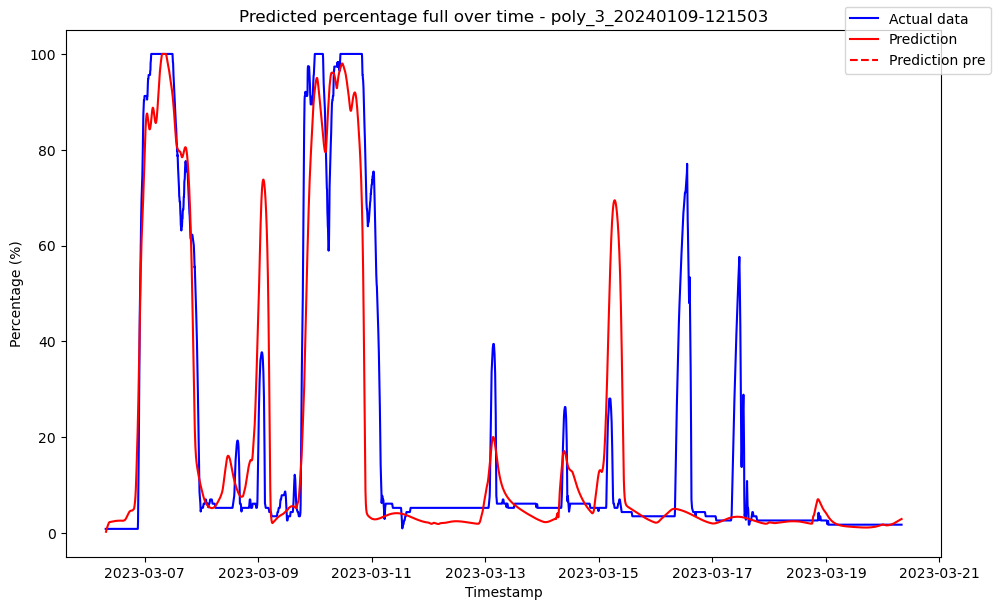

In [27]:
import glob

plot_against_actual_data = True # Only use this to predict known historical percentages

# if not train model
if not train_model:
    print('[[----- BEST MODELS ARE LOADED -----]]')
    # Loads all models from folder models\best_models
    models = {}

    # Folders
    files_linear_shuffled = glob.glob('models/best_models/fixed_data/linear_shuffled/model_*')
    files_linear_shuffled_lag = glob.glob('models/best_models/fixed_data/linear_shuffled_lag/model_*')
    files_linear_shuffled_stf = glob.glob('models/best_models/fixed_data/linear_shuffled_stf/model_*')
    files_randomforest_shuffled = glob.glob('models/best_models/fixed_data/random_forest_shuffled/model_*')
    files_random_forest_shuffled_friedman = glob.glob('models/best_models/fixed_data/random_forest_shuffled_friedman/model_*')
    files_random_forest_shuffled_lag_friedman = glob.glob('models/best_models/fixed_data/random_forest_shuffled_lag_friedman/model_*')

    # Select folders
    # files = files_linear_shuffled + files_linear_shuffled_stf + files_randomforest_shuffled + files_random_forest_shuffled_friedman
    # files = files_linear_shuffled_lag + files_random_forest_shuffled_lag_friedman
    files = glob.glob('models/best_models/model_*')
    # files = glob.glob('models/random_forest/best_model_*')

    # Sort files by name
    files.sort()

    # Load the scaler from folder models\best_models
    if optimized_lag_features:
        scaler_path = glob.glob('models/best_models/scaler_fixed_data_lag.pkl')
    else:
        scaler_path = glob.glob('models/best_models/scaler_fixed_data.pkl')

    print('scaler used:', scaler_path[0])
    scaler = pickle.load(open(scaler_path[0], 'rb'))

    for f in files:
        model_name = f.split('model_')[1].split('.pkl')[0]
        models[model_name] = pickle.load(open(f, 'rb'))

        # # Saves model with the same name, if library warns of version
        # filename = f'models/best_models/model_{model_name}.pkl'
        # save_to_pickle_file(models[model_name], filename)

        if plot_against_actual_data:
            weather_data_for_loaded_models = merged_df[(merged_df['timestamp'] >= start_timestamp_for_specific_testing - pd.Timedelta(minutes=5*percentage_lag)) & (merged_df['timestamp'] <= end_timestamp_for_specific_testing)].copy()
        else:
            weather_data_for_loaded_models = weather_data_6_months_later

        predict_test_plot(models[model_name], scaler, model_name, start_timestamp_for_specific_testing, end_timestamp_for_specific_testing, weather_data_for_loaded_models, plot_against_actual_data)
else:
    print('[[----- NEW MODEL USED -----]]')

    pred_df, pre_pred_df = create_predictions_df(start_timestamp_for_specific_testing, end_timestamp_for_specific_testing, weather_data_6_months_later, model, scaler)

    plot_predictions_and_rainfall(pred_df, pre_pred_df, 'new model')

    if(predictions_to_excel):
        # Write pred_df to excel in folder predictions
        pred_df.to_excel('predictions/pred_df_' + datetime.now().strftime("%Y%m%d-%H%M%S") + '.xlsx', index=False)
        pre_pred_df.to_excel('predictions/pre_pred_df_' + datetime.now().strftime("%Y%m%d-%H%M%S") + '.xlsx', index=False)